In [2]:
import numpy as np
import torch as th
import glob
from PIL import Image
import matplotlib.pyplot as plt
import cv2

def create_image_grid(images, n_rows=1, text_labels=[]):
    """
    Creates a grid of images from a list of NumPy arrays.
    
    Parameters:
    - images: List of np.array, each representing an image.
    - n_rows: Number of rows in the grid.
    
    Returns:
    - A matplotlib figure containing the image grid.
    """
    n_images = len(images)
    n_cols = (n_images + n_rows - 1) // n_rows  # Calculate number of columns needed
    
    # Get the height and width of the images (assuming all images are the same size)
    # img_height, img_width = images[0].shape[:2]

    # Add zero images if the number of images is less than needed to fill the grid
    images += [np.zeros_like(images[0]) for _ in range(n_rows * n_cols - n_images)]
    
    # Create the grid by concatenating images
    rows = []
    for i in range(n_rows):
        row_images = images[i * n_cols:(i + 1) * n_cols]
        rows.append(np.concatenate(row_images, axis=1))
    
    grid_image = np.concatenate(rows, axis=0)

    # Add text labels to the grid
    img_height, img_width = images[0].shape[:2]
    for i, text_label in enumerate(text_labels):
        # plt.text((i % n_cols) * img_width, (i // n_cols) * img_height, text_label, color='red', fontsize=12)
        if isinstance(text_label, str):
            plt.text((i % n_cols) * img_width, -2, text_label, color='red', fontsize=20)
        else:
            plt.text((i % n_cols) * img_width, -2, f'{float(text_label):.5f}', color='red', fontsize=20)

    return grid_image

def face_segment(segment_part, img):
    
    if isinstance(img, Image.Image):
        face_segment_anno = np.array(img)
    else:
        face_segment_anno = img
        
    bg = (face_segment_anno == 0)
    skin = (face_segment_anno == 1)
    l_brow = (face_segment_anno == 2)
    r_brow = (face_segment_anno == 3)
    l_eye = (face_segment_anno == 4)
    r_eye = (face_segment_anno == 5)
    eye_g = (face_segment_anno == 6)
    l_ear = (face_segment_anno == 7)
    r_ear = (face_segment_anno == 8)
    ear_r = (face_segment_anno == 9)
    nose = (face_segment_anno == 10)
    mouth = (face_segment_anno == 11)
    u_lip = (face_segment_anno == 12)
    l_lip = (face_segment_anno == 13)
    neck = (face_segment_anno == 14)
    neck_l = (face_segment_anno == 15)
    cloth = (face_segment_anno == 16)
    hair = (face_segment_anno == 17)
    hat = (face_segment_anno == 18)
    l_pupil = (face_segment_anno == 19)
    r_pupil = (face_segment_anno == 20)
    face = np.logical_or.reduce((skin, l_brow, r_brow, l_eye, r_eye, eye_g, l_ear, r_ear, ear_r, nose, mouth, u_lip, l_lip))

    if segment_part == 'faceseg_face':
        seg_m = face
    elif segment_part == 'faceseg_head':
        seg_m = (face | neck | hair)
    elif segment_part == 'faceseg_nohead':
        seg_m = ~(face | neck | hair)
    elif segment_part == 'faceseg_face&hair':
        seg_m = ~bg
    elif segment_part == 'faceseg_bg_noface&nohair':
        seg_m = (bg | hat | neck | neck_l | cloth) 
    elif segment_part == 'faceseg_bg&ears_noface&nohair':
        seg_m = (bg | hat | neck | neck_l | cloth) | (l_ear | r_ear | ear_r)
    elif segment_part == 'faceseg_bg':
        seg_m = bg
    elif segment_part == 'faceseg_bg&noface':
        seg_m = (bg | hair | hat | neck | neck_l | cloth)
    elif segment_part == 'faceseg_faceskin':
        seg_m = skin
    elif segment_part == 'faceseg_faceskin&nose':
        seg_m = (skin | nose)
    elif segment_part == 'faceseg_faceskin&nose&mouth&eyebrows':
        seg_m = (skin | nose | mouth | u_lip | l_lip | l_brow | r_brow | l_eye | r_eye)
    elif segment_part == 'faceseg_faceskin&nose&mouth&eyebrows&eyes&glasses':
        seg_m = (skin | nose | mouth | u_lip | l_lip | l_brow | r_brow | l_eye | r_eye | eye_g)
        # seg_m = (skin | nose | mouth | u_lip | l_lip | l_brow | r_brow)
    elif segment_part == 'faceseg_face_noglasses':
        seg_m = (~eye_g & face)
    elif segment_part == 'faceseg_face_noglasses_noeyes':
        seg_m = (~(l_eye | r_eye) & ~eye_g & face)
    elif segment_part == 'faceseg_eyes&glasses':
        seg_m = (l_eye | r_eye | eye_g)
    elif segment_part == 'faceseg_glasses':
        seg_m = eye_g
    elif segment_part == 'faceseg_hair':
        seg_m = hair
    elif segment_part == 'faceseg_eyes':
        seg_m = (l_eye | r_eye | l_pupil | r_pupil)
    elif segment_part == 'faceseg_Leye':
        seg_m = (l_eye)
    elif segment_part == 'faceseg_Reye':
        seg_m = (r_eye)
    elif segment_part == 'faceseg_ears':
        seg_m = (l_ear | r_ear | ear_r)
    elif segment_part == 'faceseg_nose':
        seg_m = nose
    elif segment_part == 'faceseg_mouth':
        seg_m = (mouth | u_lip | l_lip)
    elif segment_part == 'faceseg_neck':
        seg_m = neck
    elif segment_part == 'faceseg_pupils':
        seg_m = (l_pupil | r_pupil)
    elif segment_part == 'faceseg_eyes&ears&nose&mouth':
        seg_m = (l_eye | r_eye | l_ear | r_ear | ear_r | nose | mouth | u_lip | l_lip)
    # elif (segment_part == 'sobel_bg_mask') or (segment_part == 'laplacian_bg_mask') or (segment_part == 'sobel_bin_bg_mask'):
    elif segment_part in ['sobel_bg_mask', 'laplacian_bg_mask', 'sobel_bin_bg_mask']:
        seg_m = ~(face | neck | hair)
    elif segment_part in ['canny_edge_bg_mask']:
        seg_m = ~(face | neck | hair) | (l_ear | r_ear)
    else: raise NotImplementedError(f"Segment part: {segment_part} is not found!")
    
    out = seg_m
    return out

(256, 256, 3) (256, 256, 3)
0 17


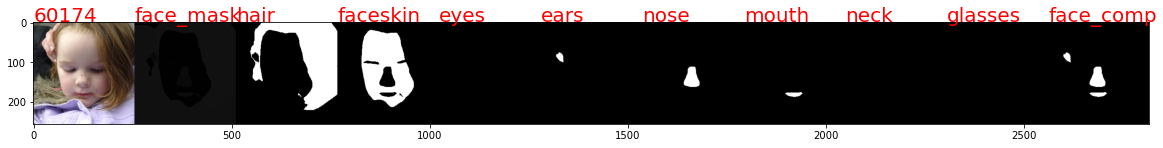

(256, 256, 3) (256, 256, 3)
0 17


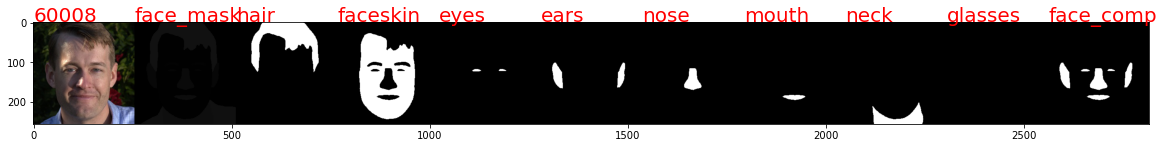

In [3]:
import numpy as np
import torch as th

# set_ = 'train'
set_ = 'valid'
path = '/data/mint/DPM_Dataset/ffhq_256_with_anno/'
img_path = f'{path}/ffhq_256/{set_}'
segm_path = f'{path}/face_segment/{set_}/anno/'

# for i, p in enumerate(glob.glob(img_path + '/*.jpg')):
for i, p in enumerate([img_path + '/60174.jpg', img_path + '/60008.jpg']):
    img_name = p.split('/')[-1].split('.')[0]
    img = np.array(Image.open(p))
    segm = np.array(Image.open(segm_path + '/anno_' + img_name + '.png'))
    segm = np.repeat(segm[..., None], 3, axis=-1)
    print(segm.shape, img.shape)
    print(segm.min(), segm.max())
    
    fig = plt.figure(figsize=(20, 10))
    plt.imshow(create_image_grid([img, 
                                  segm, 
                                  face_segment('faceseg_hair', segm)*255,
                                  face_segment('faceseg_faceskin', segm)*255,
                                  face_segment('faceseg_eyes', segm)*255,
                                  face_segment('faceseg_ears', segm)*255,
                                  face_segment('faceseg_nose', segm)*255,
                                  face_segment('faceseg_mouth', segm)*255,
                                  face_segment('faceseg_neck', segm)*255,
                                  face_segment('faceseg_glasses', segm)*255,
                                  face_segment('faceseg_eyes&ears&nose&mouth', segm)*255,
                                ], 
                                 text_labels=[img_name, 'face_mask', 'hair', 'faceskin', 'eyes', 'ears', 'nose', 'mouth', 'neck', 'glasses', 'face_comp'], n_rows=1))
    plt.show()
    if i == 10: break

# Extract eye balls (Using mediapipe)

In [4]:
!pip install -q mediapipe
!wget -O face_landmarker_v2_with_blendshapes.task -q https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task

In [5]:
#@markdown We implemented some functions to visualize the face landmark detection results. <br/> Run the following cell to activate the functions.

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import matplotlib.pyplot as plt


def draw_landmarks_on_image(rgb_image, detection_result):
  face_landmarks_list = detection_result.face_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected faces to visualize.
  for idx in range(len(face_landmarks_list)):
    face_landmarks = face_landmarks_list[idx]

    # Draw the face landmarks.
    face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    face_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
    ])

    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_tesselation_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_contours_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_IRISES,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp.solutions.drawing_styles
          .get_default_face_mesh_iris_connections_style())

  return annotated_image

def plot_face_blendshapes_bar_graph(face_blendshapes):
  # Extract the face blendshapes category names and scores.
  face_blendshapes_names = [face_blendshapes_category.category_name for face_blendshapes_category in face_blendshapes]
  face_blendshapes_scores = [face_blendshapes_category.score for face_blendshapes_category in face_blendshapes]
  # The blendshapes are ordered in decreasing score value.
  face_blendshapes_ranks = range(len(face_blendshapes_names))

  fig, ax = plt.subplots(figsize=(12, 12))
  bar = ax.barh(face_blendshapes_ranks, face_blendshapes_scores, label=[str(x) for x in face_blendshapes_ranks])
  ax.set_yticks(face_blendshapes_ranks, face_blendshapes_names)
  ax.invert_yaxis()

  # Label each bar with values
  for score, patch in zip(face_blendshapes_scores, bar.patches):
    plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{score:.4f}", va="top")

  ax.set_xlabel('Score')
  ax.set_title("Face Blendshapes")
  plt.tight_layout()
  plt.show()

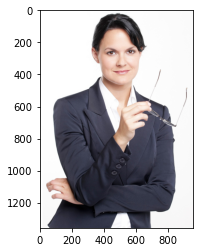

In [6]:

import cv2

img = cv2.imread("image.png")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

I0000 00:00:1718429197.709533  564451 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1718429197.840388  579946 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 470.199.02), renderer: NVIDIA GeForce RTX 2080 Ti/PCIe/SSE2
W0000 00:00:1718429197.840850  564451 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


(478, 2)
{'l_eye': [468, 469, 470, 471, 472], 'r_eye': [473, 474, 475, 476, 477], 'l_pupil': [468], 'r_pupil': [473], 'l_rad': 11.031745546102718, 'r_rad': 11.013864859597433}


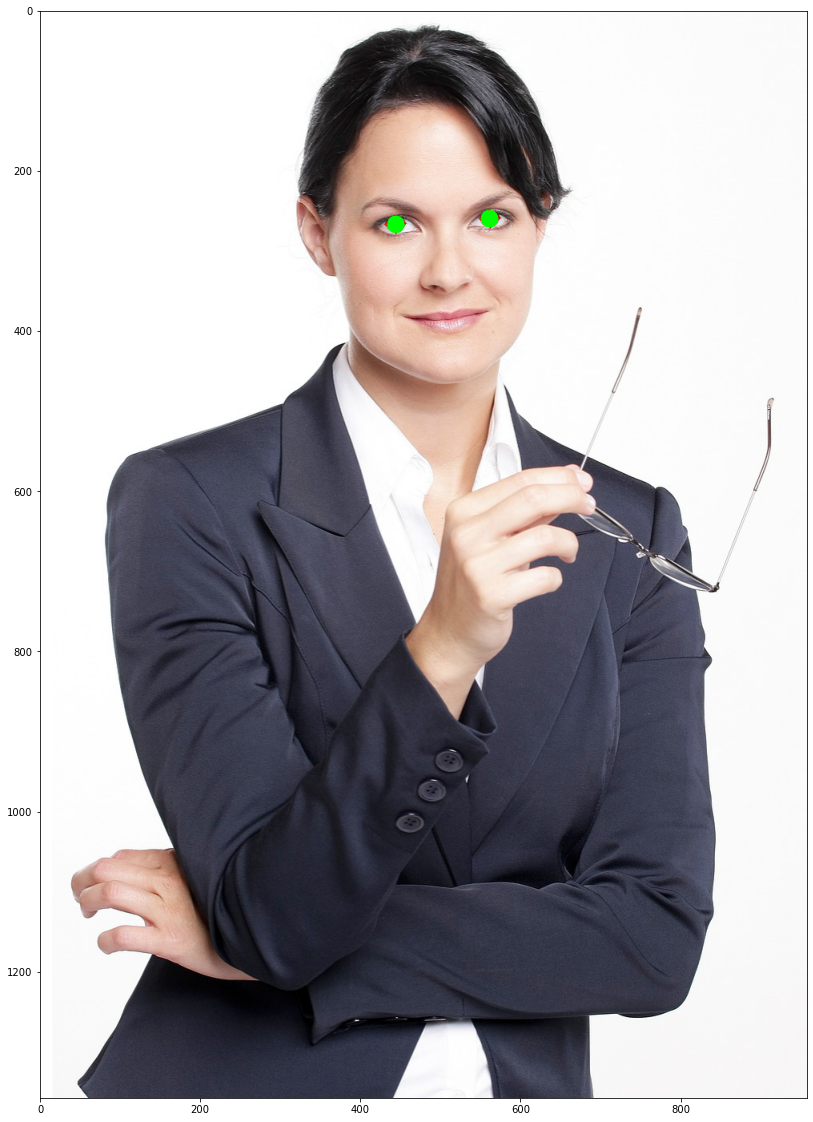

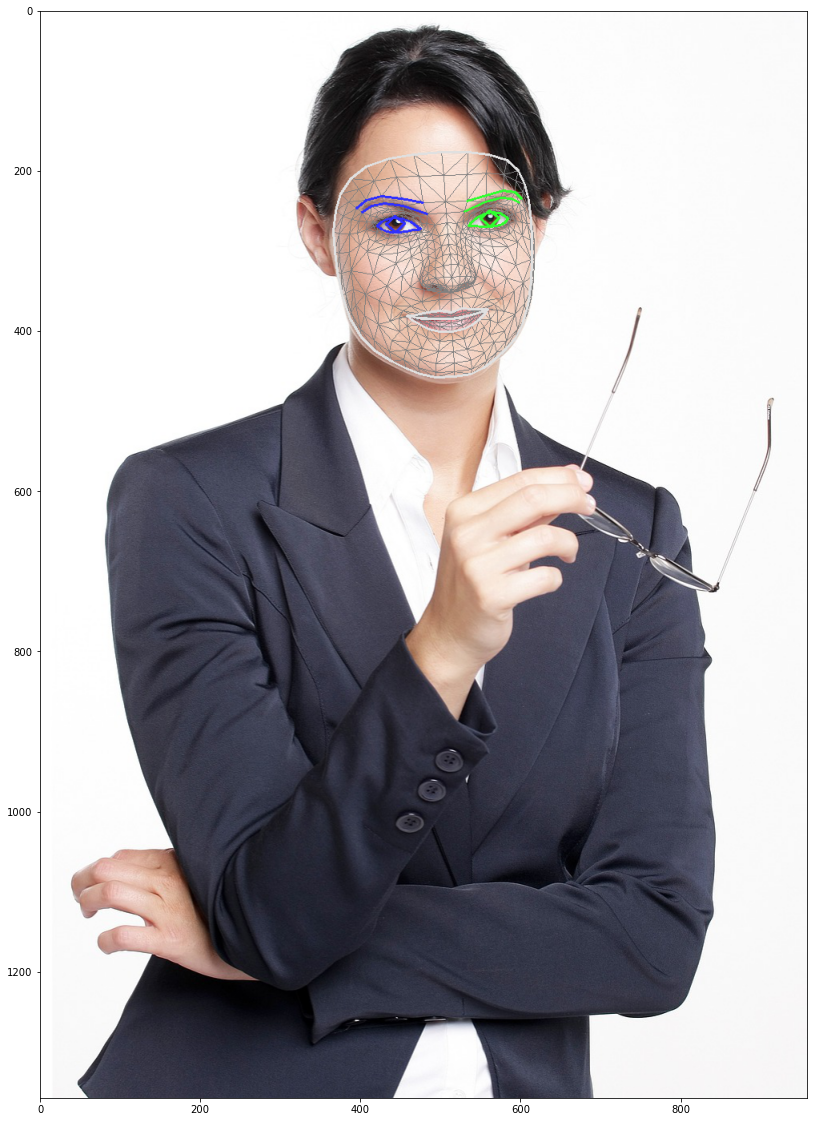

In [7]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an FaceLandmarker object.
base_options = python.BaseOptions(model_asset_path='face_landmarker_v2_with_blendshapes.task')
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file("image.png")

# STEP 4: Detect face landmarks from the input image.
detection_result = detector.detect(image)
face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
face_landmarks_proto.landmark.extend([
    landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in detection_result.face_landmarks[0]
])

face_landmarks_proto_denom = list(solutions.drawing_utils._normalized_to_pixel_coordinates(landmark.x, landmark.y, image_height=img.shape[0], image_width=img.shape[1]) for landmark in detection_result.face_landmarks[0])
face_landmarks_proto_denom = np.array(face_landmarks_proto_denom)
print(face_landmarks_proto_denom.shape)

parts = {
    'l_eye': [468, 469, 470, 471, 472],
    'r_eye': [473, 474, 475, 476, 477],
    'l_pupil': [468],
    'r_pupil': [473],
    'l_rad': np.mean(np.sqrt(np.sum((face_landmarks_proto_denom[468:469] - face_landmarks_proto_denom[469:472])**2, 1)), axis=0),
    'r_rad': np.mean(np.sqrt(np.sum((face_landmarks_proto_denom[473:474] - face_landmarks_proto_denom[474:477])**2, 1)), axis=0),
}
print(parts)
for part in ['l_eye', 'r_eye']:
    for lm in face_landmarks_proto_denom[parts[part]]:
        cv2.circle(img, (int(lm[0]), int(lm[1])), 2, (0, 0, 255), -1)  #
cv2.circle(img, (int(face_landmarks_proto_denom[468][0]), int(face_landmarks_proto_denom[468][1])), int(parts['l_rad']), (0, 255, 0), -1)  #
cv2.circle(img, (int(face_landmarks_proto_denom[473][0]), int(face_landmarks_proto_denom[473][1])), int(parts['r_rad']), (0, 255, 0), -1)  #

fig = plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# STEP 5: Process the detection result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
fig = plt.figure(figsize=(20, 20))
plt.imshow(annotated_image)
plt.show()

# Run on FFHQ

In [ ]:
import os, tqdm
def find_eyes(img, vis=False):
    name = img.split('/')[-1].split('.')[0]
    image_mp = mp.Image.create_from_file(img)
    image = np.array(Image.open(img))
    mask = f'{path}/face_segment/{set_}/anno/anno_{name}.png'
    mask = np.array(Image.open(mask))
    

    H, W, _ = image.shape

    detection_result = detector.detect(image_mp)
    if len(detection_result.face_landmarks) < 1:
        print(f"[#] No face detected in {img}")
        l_eye_mask = face_segment('faceseg_Leye', mask)
        r_eye_mask = face_segment('faceseg_Reye', mask)
        new_mask = mask.copy()
        new_mask[l_eye_mask] = 19   # L_pupil set to l_eye if no face detected
        new_mask[r_eye_mask] = 20   # R_pupil set to r_eye if no face detected
        plt.imshow(create_image_grid([
            image,
        ]))
        plt.show()
        plt.imshow(new_mask)
        plt.show()
        return new_mask 
    face_landmarks_proto_denom = list(solutions.drawing_utils._normalized_to_pixel_coordinates(landmark.x, landmark.y, image_height=H, image_width=W) for landmark in detection_result.face_landmarks[0])
    # print(len(face_landmarks_proto_denom))
    face_landmarks_proto_denom = np.array(face_landmarks_proto_denom)
    if isinstance(face_landmarks_proto_denom[0], tuple):
        print(f"[#] None detected in {img}")
        x = np.array([i[0] if i is not None and idx not in [468, 469, 470, 471, 472, 473, 474, 475, 476, 477] else 0. for idx, i in enumerate(face_landmarks_proto_denom)])
        y = np.array([i[1] if i is not None and idx not in [468, 469, 470, 471, 472, 473, 474, 475, 476, 477] else 0. for idx, i in enumerate(face_landmarks_proto_denom)])
        face_landmarks_proto_denom = np.concatenate([x[:, None], y[:, None]], axis=1)
        # plt.imshow(create_image_grid([
        #     image,
        # ]))
        # plt.show()

    # try:
    parts = {
        'l_eye': [468, 469, 470, 471, 472],
        'r_eye': [473, 474, 475, 476, 477],
        'l_pupil': [468],
        'r_pupil': [473],
        'l_rad': np.mean(np.sqrt(np.sum((face_landmarks_proto_denom[468:469] - face_landmarks_proto_denom[469:472])**2, 1)), axis=0),
        'r_rad': np.mean(np.sqrt(np.sum((face_landmarks_proto_denom[473:474] - face_landmarks_proto_denom[474:477])**2, 1)), axis=0),
    }
    # except:
    #     print(face_landmarks_proto_denom.shape)

    L_pupil_mask = np.zeros_like(image)
    R_pupil_mask = np.zeros_like(image)
    cv2.circle(L_pupil_mask, (int(face_landmarks_proto_denom[468][0]), int(face_landmarks_proto_denom[468][1])), int(parts['l_rad']), (255, 255, 255), -1)  #
    cv2.circle(R_pupil_mask, (int(face_landmarks_proto_denom[473][0]), int(face_landmarks_proto_denom[473][1])), int(parts['r_rad']), (255, 255, 255), -1)  #
    L_pupil_mask = L_pupil_mask > 128
    R_pupil_mask = R_pupil_mask > 128
    pupil_mask = L_pupil_mask | R_pupil_mask


    # print(np.unique(face_segment('faceseg_eyes', mask)), np.unique(pupil_mask))
    # print(np.unique(face_segment('faceseg_eyes', mask)), np.unique(pupil_mask))

    # Add mask=19 for L_pupil_mask and mask=20 for R_pupil_mask
    if vis:
        image_vis = image.copy()
        for part in ['l_eye', 'r_eye']:
            for lm in face_landmarks_proto_denom[parts[part]]:
                cv2.circle(image_vis, (int(lm[0]), int(lm[1])), 2, (0, 0, 255), -1)  #
        cv2.circle(image_vis, (int(face_landmarks_proto_denom[468][0]), int(face_landmarks_proto_denom[468][1])), int(parts['l_rad']), (0, 255, 0), 1)  #
        cv2.circle(image_vis, (int(face_landmarks_proto_denom[473][0]), int(face_landmarks_proto_denom[473][1])), int(parts['r_rad']), (0, 255, 0), 1)  #

        annotated_image = draw_landmarks_on_image(image_mp.numpy_view(), detection_result)

        fig = plt.figure(figsize=(50, 60))
        plt.imshow(create_image_grid([
            image,
            image * face_segment('faceseg_eyes', mask)[..., None],
            image * pupil_mask,
            image * (pupil_mask * face_segment('faceseg_eyes', mask)[..., None]),
            L_pupil_mask * face_segment('faceseg_eyes', mask)[..., None] * 255,
            R_pupil_mask * face_segment('faceseg_eyes', mask)[..., None] * 255,
            pupil_mask * 255,
            np.repeat(face_segment('faceseg_eyes', mask)[..., None], 3, axis=-1) * 255,
            pupil_mask * face_segment('faceseg_eyes', mask)[..., None] * 255,
            image_vis,
            annotated_image
        ]))
        plt.show()

    new_mask = mask.copy()
    L_pupil_mask = L_pupil_mask[..., 0] * face_segment('faceseg_eyes', mask)
    R_pupil_mask = R_pupil_mask[..., 0] * face_segment('faceseg_eyes', mask)
    new_mask[L_pupil_mask] = 19
    new_mask[R_pupil_mask] = 20
    if vis:
        plt.imshow(new_mask)
        plt.show()

    return new_mask

path = '/data/mint/DPM_Dataset/ffhq_256_with_anno/'
# set_ = 'valid'
set_ = 'train'
img_path = f'{path}/ffhq_256/{set_}/'

output = f'/data/mint/DPM_Dataset/ffhq_256_with_anno/face_segment_with_pupil/{set_}/anno/'
os.makedirs(output, exist_ok=True)
idx = 0
for img in tqdm.tqdm(glob.glob(img_path + '/*.jpg')):
    name = img.split('/')[-1].split('.')[0]
    # new_mask = find_eyes(img, vis=True)
    new_mask = find_eyes(img, vis=False)
    new_mask = Image.fromarray(new_mask)
    new_mask.save(output + f'anno_{name}.png')
    # if idx == 20: break
    # idx +=1

# Test new mask

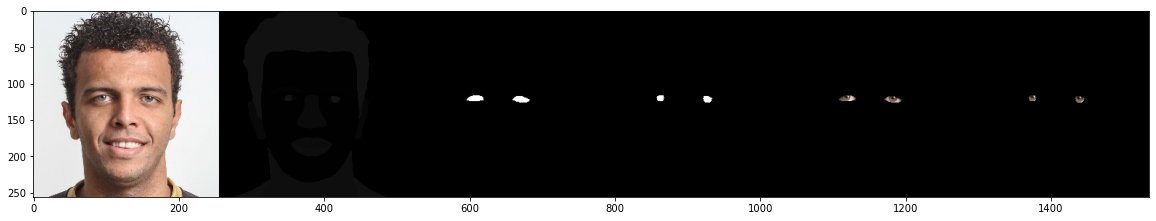

In [10]:
test_path = glob.glob(f'/data/mint/DPM_Dataset/ffhq_256_with_anno/face_segment_with_pupil/{set_}/anno/*.png')[0]
test_mask = np.array(Image.open(test_path))
test_mask = np.repeat(test_mask[..., None], 3, axis=-1)
img_name = test_path.split('/')[-1].split('.')[0].split('_')[-1]
test_img = np.array(Image.open(f'/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/{set_}/' + img_name + '.jpg'))
# test_img = np.array(Image.open('/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/valid/' + img_name + '.jpg'))
fig = plt.figure(figsize=(20, 20))
plt.imshow(create_image_grid([
    test_img,
    test_mask, 
    face_segment('faceseg_eyes', test_mask)*255,
    face_segment('faceseg_pupils', test_mask)*255,
    test_img * face_segment('faceseg_eyes', test_mask),
    test_img * face_segment('faceseg_pupils', test_mask),

]))
plt.show()